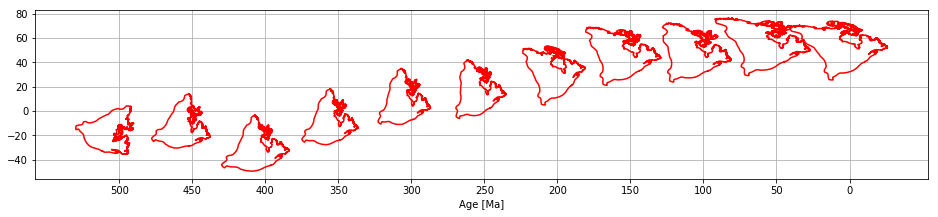

In [1]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

#########
%matplotlib inline


rotation_model = pygplates.RotationModel('Data/PALEOMAP_PlateModel.rot')
coastlines = pygplates.FeatureCollection('Data/PALEOMAP_coastlines.gpmlz')

cs = []
for coastline in coastlines:
    if coastline.get_reconstruction_plate_id()==101:
        for geometry in coastline.get_all_geometries():
            if geometry.get_area()>0.01:
                cs.append(coastline)

csf = pygplates.FeatureCollection(cs)

plt.figure(figsize=(16,4))

offset = 0
offset_factor = 60
time_list = np.arange(500,-1,-50)

for time in time_list:
    rcsf = []
    pygplates.reconstruct(csf,rotation_model,rcsf,time)
    
    for rcs in rcsf:
        #for geometry in rcs.get_reconstructed_geometry():
        mean_lon = rcs.get_reconstructed_geometry().get_boundary_centroid().to_lat_lon_point().get_longitude()
        plt.plot(rcs.get_reconstructed_geometry().to_lat_lon_array()[:,1]-mean_lon+offset,
                 rcs.get_reconstructed_geometry().to_lat_lon_array()[:,0],'r')
            
    offset += offset_factor
    
plt.xticks(np.arange(0,len(time_list),1)*offset_factor)
plt.gca().set_xticklabels(time_list)
plt.gca().set_aspect('equal')
plt.xlabel('Age [Ma]')
plt.grid()
plt.show()
    



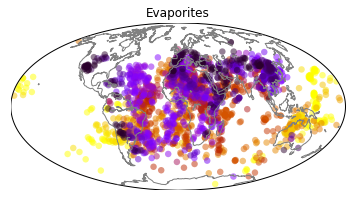

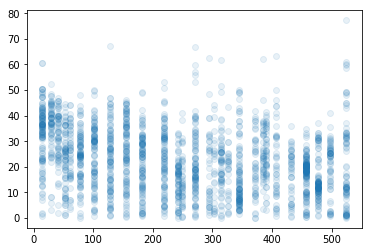

In [2]:
paleolithology_features = pygplates.FeatureCollection('Data/boucot_paleolithology_combined.shp')

def get_paleolithology(point_features,CODE,age_min=-1.,age_max=4000):
    pX = []
    pY = []
    pAge = []
    for point in point_features:
        lithcode = point.get_shapefile_attribute('LithCode')
        #print point.get_valid_time()
        if lithcode==CODE and point.get_reconstruction_plate_id()!=0 \
        and point.get_valid_time()[0]<=age_max and point.get_valid_time()[1]>=age_min:
            BirthTime = np.mean(point.get_valid_time())
            pAge.append(BirthTime)
            point_rotation = rotation_model.get_rotation(BirthTime, point.get_reconstruction_plate_id(), anchor_plate_id=0)
            reconstructed_point = point_rotation * point.get_geometry()
            pX.append(reconstructed_point.to_lat_lon()[1])
            pY.append(reconstructed_point.to_lat_lon()[0])
            
    return pX,pY,pAge


pX,pY,pAge = get_paleolithology(paleolithology_features,'E')

fig,ax = plt.subplots()
m = Basemap(projection='moll', lon_0=0, resolution='c', ax=ax)
m.drawcoastlines(color='gray')
x,y = m(pX,pY)
l = m.scatter(x,y, marker='o', c=np.asarray(pAge), s=40+(5000/len(pX)), edgecolor='none', alpha=0.5, 
              vmin=0, vmax=500, cmap=plt.cm.gnuplot)
plt.title('Evaporites')

plt.figure()
plt.plot(pAge,np.abs(pY),'o',alpha=0.1)
plt.show()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


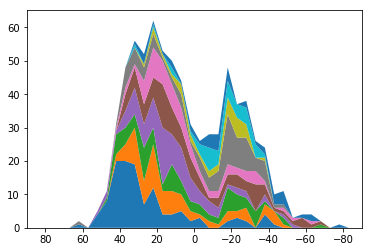

In [3]:
min_time = 0
max_time = 500
cmap = plt.cm.gnuplot_r

code = 'E'
dat = []

BinSize = 5

for age in np.arange(0,501,50):

    pX,pY,pAge = get_paleolithology(paleolithology_features,code,age,age+50)

    res = np.histogram2d(pX,pY,bins=(np.arange(-180,180.1,BinSize),np.arange(-90,90.1,BinSize)))

    dat.append(np.nansum(res[0]/res[0],axis=0))
    
plt.stackplot(res[2][:-1]+BinSize/2,dat)
plt.xlim(90,-90)
plt.show()
